# Processminer - Anomaly Detection using Autoencoder LSTM

Ref:
- https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import accuracy_score, classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

# Globals

In [2]:
MODE_RESUME = False

# --- Plot ---
FIGSIZE_SENSOR = (18, 3)


# --- Pre processing ---
SPLITSIZE_TRAIN_VALTEST = 0.4  # 0.2

# Time (in n-rows) for which to predict ahead (n * 2min)
PREDICT_AHEAD_ROWS = 4  # 2


# --- Modeling ---
# Lookback/Timestep for LSTM Model (X * 2min)
LOOKBACK = 10  # 5

N_EPOCHS = 100 #300
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Load Dataset

In [3]:
PATH = "data/processminer-rare-event-mts-data_cleaned.csv"

df_data = pd.read_csv(PATH)

df_data

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,05/01/99 00:00,0.0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,05/01/99 00:02,0.0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,05/01/99 00:04,0.0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,05/01/99 00:06,0.0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,05/01/99 00:08,0.0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20159,05/28/99 23:58,0.0,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,29.984624,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242
20160,05/29/99 00:00,0.0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,29.984624,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915698,0.010620,0.175348,-0.011235
20161,05/29/99 00:02,0.0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,29.984624,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228
20162,05/29/99 00:04,0.0,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,29.984624,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221


Observations are recorded every 2 min!

# 1. Pre-process Data

### 1.1 Get datetime object and correct index

In [4]:
FORMAT_DATETIME = '%m/%d/%y %H:%M'

df_data['datetime'] = pd.to_datetime(df_data['time'], format=FORMAT_DATETIME)
df_data.sort_values(by='datetime', ascending=True)


df_data

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,datetime
0,05/01/99 00:00,0.0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,1999-05-01 00:00:00
1,05/01/99 00:02,0.0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,1999-05-01 00:02:00
2,05/01/99 00:04,0.0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,1999-05-01 00:04:00
3,05/01/99 00:06,0.0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,1999-05-01 00:06:00
4,05/01/99 00:08,0.0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,1999-05-01 00:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20159,05/28/99 23:58,0.0,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242,1999-05-28 23:58:00
20160,05/29/99 00:00,0.0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915698,0.010620,0.175348,-0.011235,1999-05-29 00:00:00
20161,05/29/99 00:02,0.0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228,1999-05-29 00:02:00
20162,05/29/99 00:04,0.0,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221,1999-05-29 00:04:00


The observations are recorded every 2 minutes!

In [5]:
def getSensorColnames():
    cols = list( set(df_data.columns) - set(['time', 'y', 'datetime']) )
    cols = sorted(cols)
    return cols

getSensorColnames()

['x1',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x2',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x29',
 'x3',
 'x30',
 'x31',
 'x32',
 'x33',
 'x34',
 'x35',
 'x36',
 'x37',
 'x38',
 'x39',
 'x4',
 'x40',
 'x41',
 'x42',
 'x43',
 'x44',
 'x45',
 'x46',
 'x47',
 'x48',
 'x49',
 'x5',
 'x50',
 'x51',
 'x52',
 'x53',
 'x54',
 'x55',
 'x56',
 'x57',
 'x58',
 'x59',
 'x6',
 'x60',
 'x7',
 'x8',
 'x9']

### 1.2 Label Data
We will use curve shifting method here.

In [6]:
df_data['y'].value_counts()

0.0    20040
1.0      124
Name: y, dtype: int64

In [7]:
# df_data[df_data['y']==1]
# Row '912' has y=1

_CHECK_IDXS = [900, 915]

count     123.000000
mean      317.170732
std       366.838056
min        10.000000
25%        67.000000
50%       166.000000
75%       424.000000
max      1556.000000
Name: datetime, dtype: float64


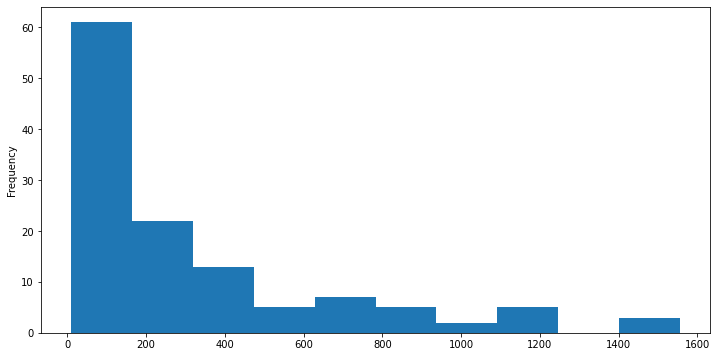

In [8]:
# Analyse the difference in time for broken state

time_diffs_min = (df_data[df_data['y']==1]['datetime'].diff().dropna().dt.total_seconds())/60
print(time_diffs_min.describe())

plt.figure(figsize=(12, 6))
_ = time_diffs_min.plot.hist()

In [9]:
# (1) Shift values 
df_data_new = df_data.copy()


y_new = df_data_new['y'].to_list()
for idx, row in df_data_new.iterrows():
    if row['y'] == 1:
        _start_idx = idx-(PREDICT_AHEAD_ROWS)
        y_new[_start_idx:idx] = [1] * (idx-_start_idx)
        
        y_new[idx] = 'DELETE'


df_data_new['label'] = y_new


# (2) Remove rows with status 'BROKEN'
df_data_new = df_data_new.drop(df_data_new[df_data_new['label'] == 'DELETE'].index)

In [10]:
# Verify
df_data_new[_CHECK_IDXS[0]:_CHECK_IDXS[1]]

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x53,x54,x55,x56,x57,x58,x59,x60,datetime,label
902,05/02/99 06:04,0.0,-0.566690,-2.589118,4.547837,119.469397,-0.089396,-11.897484,0.060853,-0.011064,...,-6.223332,2.590264,-9.477963,-76.695349,-1.470630,0.014377,4.158304,0.007816,1999-05-02 06:04:00,0
903,05/02/99 06:06,0.0,-0.536956,-2.501765,4.665909,116.854804,-0.150401,-9.249717,0.060853,-0.011064,...,-6.237736,2.588099,-6.673398,-74.537833,-0.219349,0.014530,3.063830,0.007809,1999-05-02 06:06:00,0
904,05/02/99 06:08,0.0,-0.576732,-2.508869,4.441473,121.738593,-0.211405,-8.880180,0.060853,-0.000993,...,-6.252141,2.585934,-15.766659,-72.380332,1.031932,0.014683,2.775835,0.007801,1999-05-02 06:08:00,0
905,05/02/99 06:10,0.0,-0.501962,-2.335115,4.600903,120.841345,-0.272410,-5.093437,0.060853,-0.000993,...,-6.266789,2.583769,-14.598324,-72.988593,0.391002,0.014835,3.351275,0.007794,1999-05-02 06:10:00,0
906,05/02/99 06:12,0.0,-0.465814,-2.177969,4.604120,114.512000,-0.333399,-4.898399,0.070619,0.004058,...,-6.281193,2.581605,-17.585019,-73.904151,0.391002,0.014988,4.162966,0.007787,1999-05-02 06:12:00,0
907,05/02/99 06:14,0.0,-0.477915,-2.213589,4.374481,116.803961,-0.394404,-7.952659,0.070619,0.008773,...,-6.295842,2.579440,-18.226498,-74.819708,-0.219349,0.015141,3.310152,0.007780,1999-05-02 06:14:00,0
908,05/02/99 06:16,0.0,-0.476258,-2.130090,4.658304,122.346106,-0.455409,-6.192802,0.070619,0.008773,...,-6.310246,2.577276,-28.017148,-75.735266,0.391002,0.015294,2.615946,0.007773,1999-05-02 06:16:00,1
909,05/02/99 06:18,0.0,-0.683548,-2.057296,4.477455,120.499732,-0.516413,-4.801231,0.070619,0.008773,...,-6.324894,2.575111,-35.058163,-72.113638,0.085826,0.015447,3.091593,0.007766,1999-05-02 06:18:00,1
910,05/02/99 06:20,0.0,-0.629733,-1.964926,4.587883,117.531806,-0.577403,-8.266746,0.070619,0.008773,...,-6.339299,2.572946,-26.438168,-67.357718,-0.219349,0.015600,3.994639,0.007759,1999-05-02 06:20:00,1
911,05/02/99 06:22,0.0,-0.540110,-1.877236,4.260061,124.164984,-0.638407,-4.606346,0.070619,0.008773,...,-6.353947,2.570781,-33.922055,-74.409796,-0.219349,0.015752,3.858385,0.007752,1999-05-02 06:22:00,1


In [11]:
# df_data_new[df_data_new['y']==1]

df_data_new['y'].value_counts()

0.0    20040
Name: y, dtype: int64

If you see count against value '1' then it means there were few time period in which error happended within `PREDICT_AHEAD_ROWS` because of which actual break points were also labelled as break points.

### 1.3 Obtain final data 

In [12]:
FEATURE_NAMES = getSensorColnames()

data_X = df_data_new[FEATURE_NAMES].values
data_y = df_data_new['label'].values

N_FEATS = data_X.shape[1]

print(data_X.shape, data_y.shape)
print(f"No of features: {N_FEATS}")

(20040, 59) (20040,)
No of features: 59


### 1.4 Split data into train-val-test

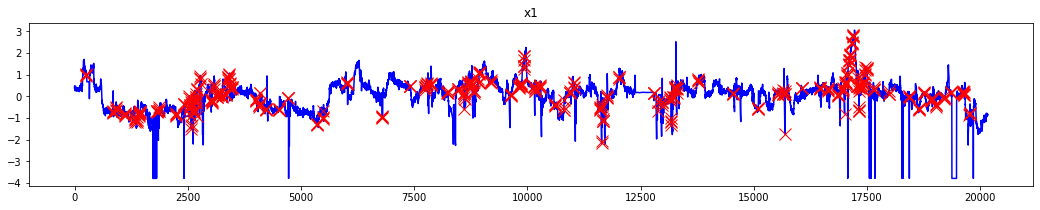

In [13]:
for sensorname in FEATURE_NAMES[:1]:
    _data_err = df_data_new[df_data_new['label']==1][sensorname]
    
    plt.figure(figsize=FIGSIZE_SENSOR)
    plt.plot(df_data_new[sensorname], color='blue')
    plt.plot(_data_err, color='red', marker='x', linestyle='none', markersize=12)
    plt.title(sensorname)

In [14]:
X_train, _X_valtest, y_train, _y_valtest = train_test_split(
    data_X, 
    data_y, 
    test_size=SPLITSIZE_TRAIN_VALTEST, 
    shuffle=False
)


# -------------------
X_val, X_test, y_val, y_test = train_test_split(
    _X_valtest,
    _y_valtest,
    test_size = 0.4,
    shuffle=False
)
# -------------------


# # -------------------
# # We are purpusely using same data for val & test since there is not enough data
# X_val = _X_valtest.copy()
# y_val = _y_valtest.copy()

# X_test = _X_valtest.copy()
# y_test = _y_valtest.copy()
# # -------------------


del _X_valtest
del _y_valtest


print(f"Train: X={X_train.shape}, y={y_train.shape}, y[label=1]={y_train.sum()}")
print(f"Val: X={X_val.shape}, y={y_val.shape}, y[label=1]={y_val.sum()}")
print(f"Test: X={X_test.shape}, y={y_test.shape}, y[label=1]={y_test.sum()}")

Train: X=(12024, 59), y=(12024,), y[label=1]=300.0
Val: X=(4809, 59), y=(4809,), y[label=1]=72.0
Test: X=(3207, 59), y=(3207,), y[label=1]=124.0


### 1.5 Obtain Normal data for training

In [15]:
X_train_normal = X_train[y_train==0]
X_val_normal = X_val[y_val==0]
X_test_normal = X_test[y_test==0]


print(f"Train Shape: {X_train_normal.shape}")
print(f"Val Shape: {X_val_normal.shape}")
print(f"test Shape: {X_test_normal.shape}")

Train Shape: (11724, 59)
Val Shape: (4737, 59)
test Shape: (3083, 59)


### 1.6 Standardize the Data (Scaling)

In [16]:
scalar = StandardScaler()

X_train_normal_scaled = scalar.fit_transform(X_train_normal)
X_val_normal_scaled = scalar.transform(X_val_normal)
X_test_normal_scaled = scalar.transform(X_test_normal)

In [17]:
# Check Standardization
def checkStandardization(data):
    """
    A correct transformation of data (X) will ensure that the means and variances of 
    each columns are 0 and 1, respectively.
    """
        
    colwise_mean = np.mean(data, axis=0).round(6)
    colwise_var = np.var(data, axis=0)
    
    return (colwise_mean, colwise_var)


print("Train: ")
print( checkStandardization(X_train_normal_scaled) )

print("Val: ")
print( checkStandardization(X_val_normal_scaled) )

print("Val: ")
print( checkStandardization(X_test_normal_scaled) )

Train: 
(array([-0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0.,
       -0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,
        0.,  0.,  0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.]))
Val: 
(array([ 2.3909100e-01,  1.3808600e-01,  1.2358600e-01,  3.5071200e-01,
        6.7709000e-02, -2.4445500e-01, -2.0806400e-01,  3.2476600e-01,
        3.2303490e+00,  4.3359070e+00, -1.5500170e+00,  2.7513800e-01,
       -7.3182400e-01,  6.2649300e-01,  3.9490920e+00,  2.1483760e+00,
       -1.4261280e+00, -2.6749000e-02,  8.3742000e-02,  3.6277100e-01,
        1.0870600e-01, -2.40795

### 1.7 Prepare Input Data for LSTM (Temporalize)

In [18]:
def createTimeseriesSequence(X, y, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with 
              X, i.e. y[i] should correspond to X[i]. 
              Shape: n_observations.
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback+1) x lookback x  n_features)
    output_y  A 1D array of shape: 
              (n_observations-lookback+1), aligned with X.
    '''
    
    output_X = []
    output_y = []
    for i in range(0, X.shape[0]-lookback+1):
        t = []
        for j in range(lookback):
            t.append(X[(i+j), :])
        
        output_X.append(t)
        output_y.append(y[i + lookback-1])   # Take the last label in the sequence
        
    return np.array(output_X), np.array(output_y)

In [19]:
X_train_final, y_train_final = createTimeseriesSequence(X_train_normal_scaled, y_train, lookback=LOOKBACK)
X_val_final, y_val_final = createTimeseriesSequence(X_val_normal_scaled, y_val, lookback=LOOKBACK)
X_test_final, y_test_final = createTimeseriesSequence(X_test_normal_scaled, y_test, lookback=LOOKBACK)


print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(11715, 10, 59)
(4728, 10, 59)
(3074, 10, 59)


# 2. Modeling

In [20]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
if MODE_RESUME:
    raise Exception("Force Stopped! Go to the cell `[R] Resume Model`.")

## 2.1 LSTM Model

In [22]:
# ----- Model: 1 -----

# activation = 'relu'   # LSTM does not use CuDNN with relu
activation = 'tanh'

kernel_regularizer = None #l2(0.01)
recurrent_regularizer = None #l2(0.01)
bias_regularizer = None #l2(0.01)


# --- Build Model ---
model = Sequential()

# Encoder
model.add( layers.LSTM(
    32, 
    input_shape=(LOOKBACK, N_FEATS), 
    activation=activation, 
    kernel_regularizer=kernel_regularizer, 
    recurrent_regularizer=recurrent_regularizer, 
    bias_regularizer=bias_regularizer, 
    return_sequences=True, name='encoder_lstm_1') 
)
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(
    16, 
    activation=activation, 
    kernel_regularizer=kernel_regularizer, 
    recurrent_regularizer=recurrent_regularizer, 
    bias_regularizer=bias_regularizer,
    return_sequences=True, 
    name='encoder_lstm_2') 
)
model.add( layers.Dropout(0.2) )


# Decoder
model.add( layers.LSTM(
    16, 
    activation=activation, 
    kernel_regularizer=kernel_regularizer, 
    recurrent_regularizer=recurrent_regularizer, 
    bias_regularizer=bias_regularizer,
    return_sequences=True, 
    name='decoder_lstm_1') 
)
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(
    32, 
    activation=activation, 
    kernel_regularizer=kernel_regularizer, 
    recurrent_regularizer=recurrent_regularizer, 
    bias_regularizer=bias_regularizer,
    return_sequences=True, 
    name='decoder_lstm_2') 
)
model.add( layers.Dropout(0.2) )


# Output
model.add( layers.TimeDistributed( layers.Dense(N_FEATS), name='output') )


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_lstm_1 (LSTM)        (None, 10, 32)            11776     
_________________________________________________________________
dropout (Dropout)            (None, 10, 32)            0         
_________________________________________________________________
encoder_lstm_2 (LSTM)        (None, 10, 16)            3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
decoder_lstm_1 (LSTM)        (None, 10, 16)            2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
decoder_lstm_2 (LSTM)        (None, 10, 32)            6

In [23]:
# Compile
optimizer = optimizers.Adam(LEARNING_RATE)

model.compile(optimizer=optimizer, loss='mse')

## 2.2 Training

In [24]:
H = model.fit(
    x = X_train_final,
    y = X_train_final,
    epochs = N_EPOCHS,
    batch_size = BATCH_SIZE, 
    validation_data = (X_val_final, X_val_final),
    verbose=1
)

Epoch 1/100
184/184 [==============================] - 6s 11ms/step - loss: 0.9923 - val_loss: 39.8358
Epoch 2/100
184/184 [==============================] - 1s 6ms/step - loss: 0.9403 - val_loss: 39.7698
Epoch 3/100
184/184 [==============================] - 1s 6ms/step - loss: 0.8711 - val_loss: 39.6374
Epoch 4/100
184/184 [==============================] - 1s 6ms/step - loss: 0.8181 - val_loss: 39.5354
Epoch 5/100
184/184 [==============================] - 1s 6ms/step - loss: 0.7848 - val_loss: 39.4691
Epoch 6/100
184/184 [==============================] - 1s 6ms/step - loss: 0.7625 - val_loss: 39.4181
Epoch 7/100
184/184 [==============================] - 1s 6ms/step - loss: 0.7458 - val_loss: 39.3699
Epoch 8/100
184/184 [==============================] - 1s 6ms/step - loss: 0.7298 - val_loss: 39.3073
Epoch 9/100
184/184 [==============================] - 1s 6ms/step - loss: 0.7157 - val_loss: 39.2448
Epoch 10/100
184/184 [==============================] - 1s 6ms/step - loss: 0.702

184/184 [==============================] - 1s 6ms/step - loss: 0.4782 - val_loss: 37.6645
Epoch 81/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4776 - val_loss: 37.6668
Epoch 82/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4769 - val_loss: 37.6557
Epoch 83/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4751 - val_loss: 37.6416
Epoch 84/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4747 - val_loss: 37.6388
Epoch 85/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4726 - val_loss: 37.6072
Epoch 86/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4724 - val_loss: 37.6185
Epoch 87/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4713 - val_loss: 37.6023
Epoch 88/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4698 - val_loss: 37.6083
Epoch 89/100
184/184 [==============================] - 1s 6ms/step - loss: 0.4680 - v

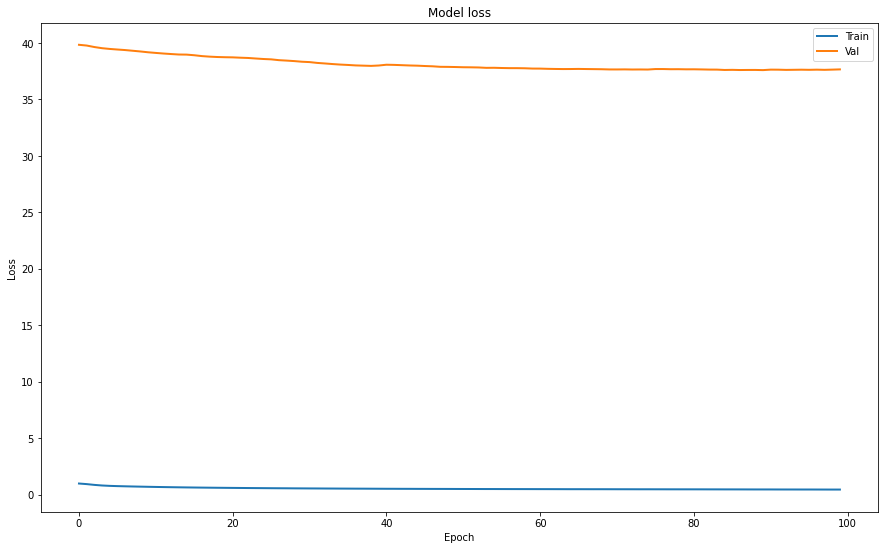

In [25]:
plt.figure(figsize=(15,9))
plt.plot(H.history['loss'], linewidth=2, label='Train')
plt.plot(H.history['val_loss'], linewidth=2, label='Val')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [26]:
# Save Model
SUFFIX = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
DIR_MODEL = os.path.join(os.getcwd(), 'model')
PATH_MODEL = os.path.join(DIR_MODEL, f'model_processminer_autoencLSTM_{SUFFIX}.h5')
PATH_SCALAR = os.path.join(DIR_MODEL, f'scalar-{SUFFIX}.pkl')


if not os.path.exists(DIR_MODEL):
    os.makedirs(DIR_MODEL)
    

model.save(PATH_MODEL)
pickle.dump(scalar, open(PATH_SCALAR, 'wb'))


print(f"Model saved to: {PATH_MODEL}")

Model saved to: /home/gagan/Work/ai-ml-cv/anomaly-detection/processminer/model/model_processminer_autoencLSTM_2021-07-26-19-35-30.h5


### [R] Resume Model

Comment the below code if you started from scratch.

In [27]:
if MODE_RESUME:
    # Load Model from disk
    model = load_model("model/model_processminer_autoencLSTM___.h5")
    scalar = pickle.load(open('model/scalar-___.pkl', 'rb'))
    
    model.summary()